**Monash University**

**FIT5202 - Data processing for Big Data**

**Assignment 2: Detecting Linux system hacking activities Part B**

---

Name: Prajyot Nagrale

Student ID: 31132324

---

## 3. Streaming application using Spark Structured Streaming (60%)
In this task, we will implement Spark Structured Streaming to consume the data from task 1
and perform predictive analytics.
Important :
  In this task, use Spark Structured Streaming together with Spark SQL and ML
  You are also provided with a set of pre-trained pipeline models, one for
predicting attack in process data, another for predicting attack in memory data
Write a python program that achieves the following requirements. Save the file as
Assignment-2B-Task3_streaming_application. ipynb .

# 1. 
SparkSession is created using a SparkConf object, which would use two local cores
with a proper application name, and use UTC as the timezone 3 (4%)


In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession # Import SparkSession
from pyspark.sql.functions import explode # import exploded
from pyspark.sql.functions import split # import split
from pyspark.sql import functions as F # import functions as F
from pyspark.ml import PipelineModel # import pipelineModel
import zipfile # import zipfile
from pyspark.sql.functions import window # import windows
from pyspark.sql.functions import udf # import udf
from pyspark.sql.functions import col # import col
from array import array # import array
from pyspark.sql.types import * # import all datatype
import matplotlib.pyplot as plt
%matplotlib notebook
from time import sleep# Import sleep 
from pyspark.sql.functions import expr

In [2]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[2]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Parallel Search"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# 2. 
From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark
Streaming for both process and memory activities(3%)


In [3]:
# connecting to kafka server # attach topic
topic_p = "process"
df_p = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic_p) \
    .load()

topic_m = "memory"
df_m = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic_m) \
    .load()

#### Changing the datatype and removing the nesting 

In [4]:
df_p = df_p.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)") # key value in string
df_m = df_m.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")# key value in string

In [5]:
#Define the schema for the structured datastream received
schema = ArrayType(StructType([    
    StructField('sequence', IntegerType(), True), 
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('TRUN', IntegerType(), True), 
    StructField('TSLPI', IntegerType(), True),
    StructField('TSLPU', IntegerType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', IntegerType(), True), 
    StructField('PRI', IntegerType(), True),
    StructField('RTPR', IntegerType(), True),
    StructField('CPUNR', IntegerType(), True), 
    StructField('Status', StringType(), True),
    StructField('EXC', IntegerType(), True),
    StructField('State', StringType(), True), 
    StructField('CPU', DoubleType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', IntegerType(), True)
]))

In [6]:
df_p = df_p.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value')) # Change the datatype of value to string

In [7]:
df_p = df_p.select(F.explode(F.col("parsed_value")).alias('unnested_value'))  # Removing nesting

In [8]:
# removing nesting
df_p_formatted = df_p.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.TRUN").alias("TRUN"),
                    F.col("unnested_value.TSLPI").alias("TSLPI"),
                    F.col("unnested_value.TSLPU").alias("TSLPU"),
                    F.col("unnested_value.POLI").alias("POLI"),
                    F.col("unnested_value.NICE").alias("NICE"),
                    F.col("unnested_value.PRI").alias("PRI"),
                    F.col("unnested_value.RTPR").alias("RTPR"),
                    F.col("unnested_value.CPUNR").alias("CPUNR"),
                    F.col("unnested_value.Status").alias("Status"),
                    F.col("unnested_value.EXC").alias("EXC"),
                    F.col("unnested_value.State").alias("State"),
                    F.col("unnested_value.CPU").alias("CPU"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [9]:
#Define the schema for the structured datastream received
schema_m = ArrayType(StructType([    
    StructField('sequence', IntegerType(), True), 
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('MINFLT', StringType(), True),
    StructField('MAJFLT', StringType(), True), 
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', StringType(), True),
    StructField('RSIZE', StringType(), True),
    StructField('VGROW', StringType(), True), 
    StructField('RGROW', StringType(), True),
    StructField('MEM', DoubleType(), True),
    StructField('CMD', StringType(), True), 
    StructField('ts', IntegerType(), True)
]))

In [10]:
df_m = df_m.select(F.from_json(F.col("value").cast("string"), schema_m).alias('parsed_value')) # Value to defined schema

In [11]:
df_m = df_m.select(F.explode(F.col("parsed_value")).alias('unnested_value'))# Remove nesting

In [12]:
# Remove nesting
df_m_formatted = df_m.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.MINFLT").alias("MINFLT"),
                    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
                    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
                    F.col("unnested_value.VSIZE").alias("VSIZE"),
                    F.col("unnested_value.RSIZE").alias("RSIZE"),
                    F.col("unnested_value.VGROW").alias("VGROW"),
                    F.col("unnested_value.RGROW").alias("RGROW"),
                    F.col("unnested_value.MEM").alias("MEM"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [13]:
#Schema
df_p_formatted.printSchema()
df_m_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: string (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: strin

# 3. 
Then the streaming data format should be transformed into the proper formats
following the metadata file schema for both process and memory, similar to
assignment 2A 4 (3%) - The numeric values with extra spaces or “K” / “M” / “G” should be properly
transformed into their correct values - The NICE value should also be restored based on the PRI values using their
relationship 5 - Hint - There is a mapping between PRI (priority) and NICE, as long as
the process is not yet finished during the last interval. For example, - PRI 100 maps to NICE -20 - PRI 101 maps toNICE -19 - … - PRI 139 maps to NICE 19 - Hint - If the process is finished, PRI and NICE would both be 0.


In [14]:
# Change the value of from the data
 # if K then 1000
 # if M then 1000000
 # if G then 1000000000
 # remove unwanted space
filter_data_m = udf(lambda x: float(x[0: -1])*1000 if 'K' in x \
                  else (float(x[0:-1])*1000000 if 'M' in x \
                  else (float(x[0:-1])*1000000000 if 'G' in x \
                  else (x.replace(" ", "") if " " in x \
                        else x ))))

In [15]:
clms = ['MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW']
for c in clms:
    df_m_formatted = df_m_formatted.withColumn(c, filter_data_m(col(c)).cast('double')) # Remove for the columns and change the datatype to double


In [16]:
filter_data_p = udf(lambda x: int(x-120) if x != 0 else 0) # Subtract PRI value by 120 and save in NICE

df_p_formatted = df_p_formatted.withColumn("NICE", filter_data_p("PRI").cast("int"))

4. For process and memory, respectively, create a new column “CMD_PID”
concatenating “CMD” and “PID” columns, and a new column “event_time” as
timestamp format based on the unix time in “ts” column (5%)- Allow 20-second tolerance for possible data delay on “event_time” using
watermarking


In [17]:
# “CMD_PID”
# Concatinate CMD and PID
from pyspark.sql import functions as sf
concat_p_CMD_PID = df_p_formatted.withColumn('CMD_PID', 
                                         sf.concat(sf.col('CMD'),
                                                   sf.lit('_'), 
                                                   sf.col('PID')))

In [18]:
# Concatinate CMD and PID
concat_m_CMD_PID = df_m_formatted.withColumn('CMD_PID', 
                                         sf.concat(sf.col('CMD'),
                                                   sf.lit('_'), 
                                                   sf.col('PID')))

In [19]:
#Change ts datatype to event_time timestamp
df_p_final = concat_p_CMD_PID.withColumn('event_time', 
                                        F.col('ts').cast('timestamp'))

In [20]:
#Change ts datatype to event_time timestamp
df_m_final = concat_m_CMD_PID.withColumn('event_time', 
                                        F.col('ts').cast('timestamp'))

In [21]:
# Create watermark for 20 seconds
df_p_final_wm = df_p_final \
    .withWatermark("event_time", "20 seconds")

In [22]:
# Create watermark for 20 seconds
df_m_final_wm = df_m_final \
    .withWatermark("event_time", "20 seconds")

In [23]:
# query = df_p_final_wm \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [24]:
# query.stop()

# 5. 
Persist the transformed streaming data in parquet format for both process and
memory (5%)  The process data should be stored in “process.parquet” in the same folder of
your notebook, and the memory data should be stored in “memory.parquet” in
the same folder of your notebook


In [25]:
# Write into parquet files the unsuccessful requests partitioned by status code
query_file_sink_p = df_p_final_wm.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process.parquet/clickstream_df")\
        .option("checkpointLocation", "process.parquet/clickstream_df/checkpoint")\
        .start()

In [26]:
#Stop the file_sink query
query_file_sink_p.stop()

In [27]:
# Write into parquet files the unsuccessful requests partitioned by status code
query_file_sink_m = df_m_final_wm.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "memory.parquet/clickstream_df")\
        .option("checkpointLocation", "memory.parquet/clickstream_df/checkpoint")\
        .start()

In [28]:
#Stop the file_sink query
query_file_sink_m.stop()

### Read the saved parquet data

In [29]:
# Read the saved parquet data
query_file_sink_df_p = spark.read.parquet("process.parquet/clickstream_df")
query_file_sink_df_p.printSchema()
query_file_sink_df_p.show()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)

+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+----+--------------+----------+-------------------+-------------------+
|sequence|machine| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State| CPU|           CMD|        ts|            C

In [30]:
# Read the saved parquet data
query_file_sink_df_m = spark.read.parquet("memory.parquet/clickstream_df")
query_file_sink_df_m.printSchema()
query_file_sink_df_m.show()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)

+--------+-------+-----+------+------+-------+-------+-------+-----+-----+----+--------------+----------+-------------------+-------------------+
|sequence|machine|  PID|MINFLT|MAJFLT| VSTEXT|  VSIZE|  RSIZE|VGROW|RGROW| MEM|           CMD|        ts|            CMD_PID|         event_time|
+--------+-------+-----+------+------+-------+-------+-------+-----+-----+----+--------------+----------+-------------------+---------

6. Load the machine learning models given 6 , and use the models to predict whether
each process or memory streaming record is an attack event, respectively (5%)


In [31]:
# Unzip file
with zipfile.ZipFile("process_pipeline_model.zip","r") as zip_ref:
    zip_ref.extractall()

In [32]:
# Unzip file
with zipfile.ZipFile("memory_pipeline_model.zip","r") as zip_ref:
    zip_ref.extractall()

In [33]:
# Load model 
process_model = PipelineModel.load('process_pipeline_model')
memory_model = PipelineModel.load('memory_pipeline_model')

In [34]:
# Transform the model to the data
pipelined_model_p = process_model.transform(df_p_final_wm)
pipelined_model_m = memory_model.transform(df_m_final_wm)

In [35]:
# query = pipelined_model_m \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [36]:
# query.stop()

7. Using the prediction result, and monitor the data following the requirements below
(30%)
a. If any program in one machine is predicted as an attack in EITHER process
or memory activity prediction, it could be a false alarm or a potential attack.
Keep track of the approximate count of such events in every 2-min window
for each machine for process and memory, respectively, and write the stream
into Spark Memory sink using complete mode 7
 Your aggregated result should include machine ID, the time window,
and the counts
 Note that if there are more than one entries having the SAME
“CMD_PID” in a 2-min window, get the approximate distinct count
 For example, if two or more records of “atop” program with the
exact same “CMD_PID” are predicted as an attack in the
process between 2020-10-10 10:10:10 and 2020-10-10
10:11:09 , only need to count this “atop” program attack once.

In [37]:
# process
# create 2 min window for each machine which has same CMD_PID
df_p_att = pipelined_model_p \
    .filter(pipelined_model_p['prediction'] == 1.0) \
    .groupBy('machine', 'CMD_PID', window(pipelined_model_p['event_time'], "120 seconds")) \
    .agg(F.sum('prediction').alias('count')) \
    .select("machine", "window", "count") \
    .sort("window")

In [38]:
# Output complete data to memory
query_mem_p = df_p_att \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("all_values_p") \
    .trigger(processingTime='5 seconds') \
    .start()

In [39]:
# spark.sql("select * from all_values_p").show()

In [40]:
# query_mem_p.stop()

In [41]:
# memory
# create 2 min window for each machine which has same CMD_PID
df_m_att = pipelined_model_m \
    .filter(pipelined_model_m['prediction'] == 1.0) \
    .groupBy('machine', 'CMD_PID', window(pipelined_model_m['event_time'], "120 seconds")) \
    .agg(F.sum('prediction').alias('count')) \
    .select("machine", "window", "count") \
    .sort("window")

In [42]:
# Output complete data to memory
query_mem_m = df_m_att \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("all_values_m") \
    .trigger(processingTime='5 seconds') \
    .start()

In [43]:
# spark.sql("select * from all_values_m").show()

In [44]:
# query_mem_m.stop()

b. If a program in one machine, having the same “CMD” and “PID” in both
process and memory streaming data, is predicted as an attack in BOTH
process and memory activity prediction, then this is considered as an attack
event. Find the streaming events fulfilling the criteria, create a new column to
record the processing time 8 and persist them in parquet.
 Note the program with the same “CMD” and “PID” might not be
generated at the exact same event time. If the difference between the
event times in process and memory is less than 30 seconds and the
program fulfills the criteria of matching “CMD” and “PID”, then you
should include them for the above checking.
 If there are multiple entries fulfilling the above criteria in process or
memory, do not remove the extra entries
 Persist the program’s relevant information (including process &
memory data, process & memory’s event and processing timestamp,

In [45]:
# Change name and get prediction of attack
attack_p = pipelined_model_p \
    .filter(pipelined_model_p['prediction'] == 1.0) \
    .selectExpr("CMD_PID AS CMD_PID_p", "machine AS machine_p", "event_time AS event_time_p")

In [46]:
# Change name and get prediction of attack
attack_m = pipelined_model_m \
    .filter(pipelined_model_m['prediction'] == 1.0) \
    .selectExpr("CMD_PID AS CMD_PID_m", "machine AS machine_m", "event_time AS event_time_m")

In [47]:
# Join  process and memory data and create a column event_time with difference between the event time of process and memory
joined_attack = attack_p.join(attack_m,expr("""CMD_PID_p == CMD_PID_m and machine_p == machine_m"""),"inner") \
                                .withColumn("event_time", F.abs(F.col("event_time_p").cast("long") - F.col("event_time_m").cast("long"))) 
                                

In [48]:
# The difference of event_time less then 30 seconds
joined_time = joined_attack.filter(joined_attack['event_time'] < 30) \
                    .withColumn('process_time', F.current_timestamp())

In [49]:
# Write into parquet files the unsuccessful requests partitioned by status code
join_sink = joined_time.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process_memory_attack.parquet/clickstream_df")\
        .option("checkpointLocation", "process_memory_attack.parquet/clickstream_df/checkpoint")\
        .start()

In [50]:
join_sink.stop()

In [51]:
# Read the saved parquet data
query_file_sink_df_m = spark.read.parquet("memory.parquet/clickstream_df")
query_file_sink_df_m.printSchema()
query_file_sink_df_m.show()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)

+--------+-------+-----+------+------+-------+-------+-------+-----+-----+----+--------------+----------+-------------------+-------------------+
|sequence|machine|  PID|MINFLT|MAJFLT| VSTEXT|  VSIZE|  RSIZE|VGROW|RGROW| MEM|           CMD|        ts|            CMD_PID|         event_time|
+--------+-------+-----+------+------+-------+-------+-------+-----+-----+----+--------------+----------+-------------------+---------

8. Visualise the data in line charts for step 7a (5%)
 For the count of suspect attacks for each machine in step 7a, use Spark SQL
to query the data from Spark Memory sink, and prepare a line chart plot for
showing the count of suspect attacks for each machine at each 2-min window
from the start to the most recent, and refresh the plot every 10 minutes
 Hint - x-axis can be used to represent the timeline, while y-axis can be
used to represent the count; each machine’s line data can be
represented in different color legends

In [52]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Process attack count') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ax:
        print(str(ax))

<IPython.core.display.Javascript object>


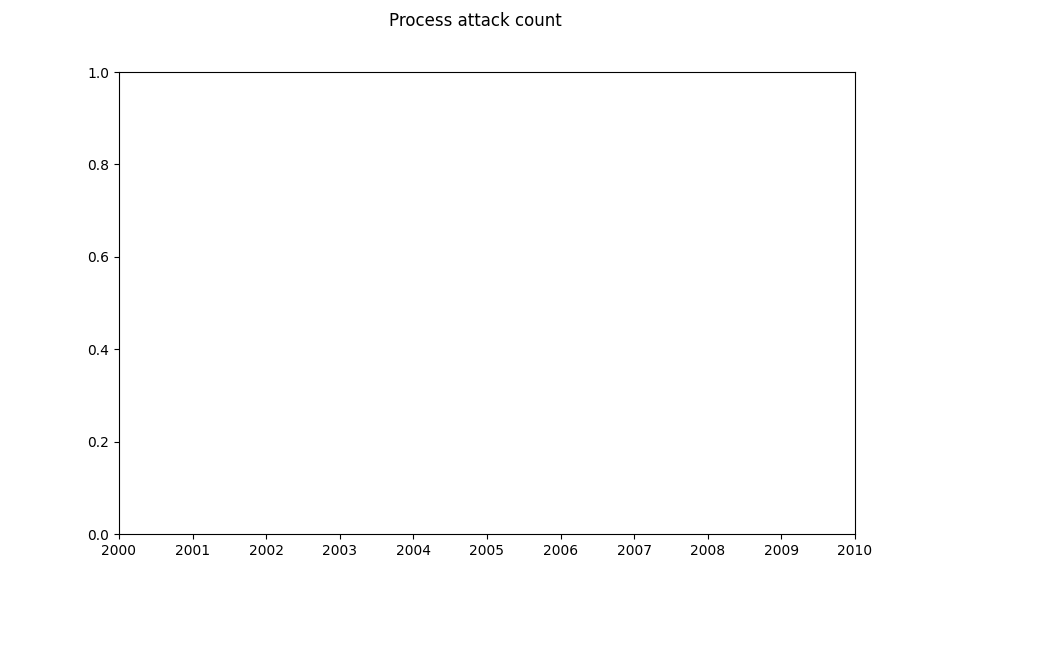

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

In [53]:
# process data
fig, ax = init_plots() # dimension for graph

while True:
    # Create dataframe with value of each machine
    memory_4 = spark.sql("select * from all_values_p where machine = 4").toPandas()
    memory_5 = spark.sql("select * from all_values_p where machine = 5").toPandas()
    memory_6 = spark.sql("select * from all_values_p where machine = 6").toPandas()
    memory_7 = spark.sql("select * from all_values_p where machine = 7").toPandas()
    memory_8 = spark.sql("select * from all_values_p where machine = 8").toPandas()
    # Create list of windows for each machine
    x_4 = memory_4['window'].tolist()
    x_5 = memory_5['window'].tolist()
    x_6 = memory_6['window'].tolist()
    x_7 = memory_7['window'].tolist()
    x_8 = memory_8['window'].tolist()
    # Create list of count for each machine
    y_4 = memory_4['count'].tolist()
    y_5 = memory_5['count'].tolist()
    y_6 = memory_6['count'].tolist()
    y_7 = memory_7['count'].tolist()
    y_8 = memory_8['count'].tolist()
#     print(x_4, y_4, x_5, y_5, x_6, y_6, x_7, y_7, x_8, y_8)

#     Plot graph
    ax.clear()
    for i, j in enumerate(x_4):
        ax.plot(x_4[i], y_4[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_5):
        ax.plot(x_5[i], y_5[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_6):
        ax.plot(x_6[i], y_6[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_7):
        ax.plot(x_7[i], y_7[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_8):
        ax.plot(x_8[i], y_8[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    ax.plot(x_5, y_5)
    
    
    sleep(5)

In [54]:
query_mem_p.stop()

In [55]:
# Memory data
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Memory attack count') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ax:
        print(str(ax))

<IPython.core.display.Javascript object>


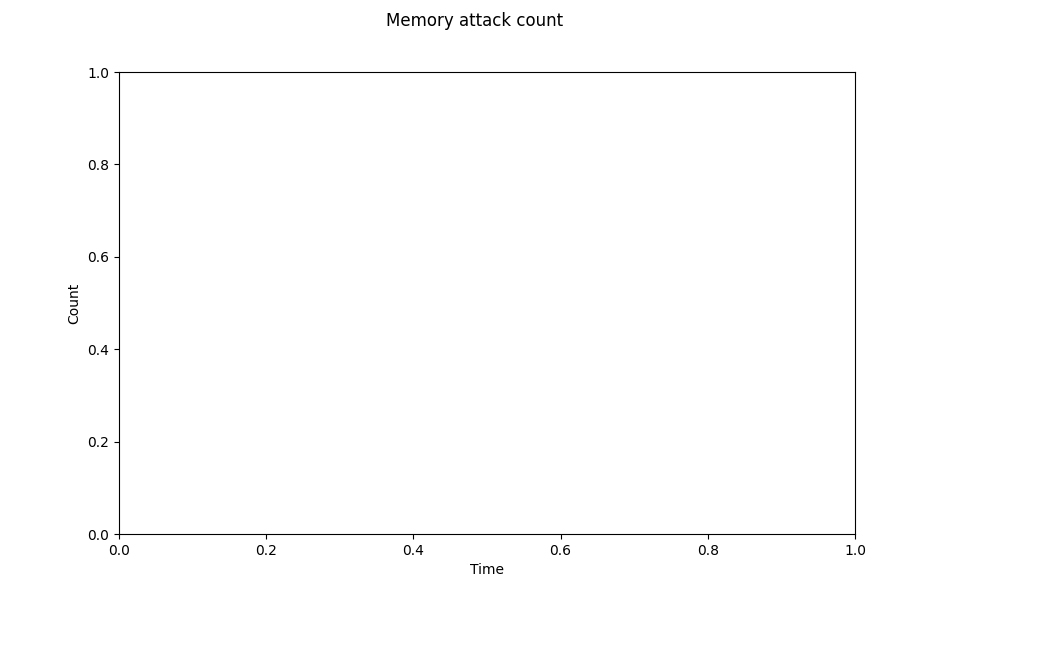

KeyboardInterrupt: 

In [56]:
fig, ax = init_plots() # dimension for graph

while True:
    # Create dataframe with value of each machine
    memory_4 = spark.sql("select * from all_values_m where machine = 4").toPandas()
    memory_5 = spark.sql("select * from all_values_m where machine = 5").toPandas()
    memory_6 = spark.sql("select * from all_values_m where machine = 6").toPandas()
    memory_7 = spark.sql("select * from all_values_m where machine = 7").toPandas()
    memory_8 = spark.sql("select * from all_values_m where machine = 8").toPandas()
    # Create list of windows for each machine
    x_4 = memory_4['window'].tolist()
    x_5 = memory_5['window'].tolist()
    x_6 = memory_6['window'].tolist()
    x_7 = memory_7['window'].tolist()
    x_8 = memory_8['window'].tolist()
    # Create list of count for each machine
    y_4 = memory_4['count'].tolist()
    y_5 = memory_5['count'].tolist()
    y_6 = memory_6['count'].tolist()
    y_7 = memory_7['count'].tolist()
    y_8 = memory_8['count'].tolist()
    # Plot graph
    ax.clear()
    for i, j in enumerate(x_4):
        ax.plot(x_4[i], y_4[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_5):
        ax.plot(x_5[i], y_5[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_6):
        ax.plot(x_6[i], y_6[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_7):
        ax.plot(x_7[i], y_7[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    for i, j in enumerate(x_8):
        ax.plot(x_8[i], y_8[i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        fig.canvas.draw()
    ax.plot(x_5, y_5)
    
    sleep(5)

In [57]:
query_mem_m.stop()